# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scrnatools as rna
import numpy as np
import pandas as pd
import pickle
from scipy.stats import ttest_ind, tukey_hsd

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

# Import data

In [5]:
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [6]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs_final.h5ad")
scores = pd.read_csv("../../analysis/entropy/cell_x_gene_atlas_cell_type_entropy.csv", index_col=0)
scores = scores[scores.index.isin(adata.var_names)].copy()
adata = adata[:, adata.var_names.isin(scores.index)].copy()

In [7]:
# cellxgene epithelial cells
cell_x_gene_exprs = np.load(f"{processedDataPath}cell_x_gene_atlas/expression/cell_x_gene_atlas_expression.npy")
genes = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/keep_genes.csv")["feature_name"]
cells = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/obs_names.csv")['0']
metadata = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/cell_metadata.csv", index_col=0)
cell_x_gene_exprs = pd.DataFrame(cell_x_gene_exprs, columns=genes)
cell_x_gene_exprs["cell_type"] = metadata.cell_type.values
cell_x_gene_exprs = cell_x_gene_exprs[cell_x_gene_exprs.cell_type.str.contains("epithelial")]
del cell_x_gene_exprs["cell_type"]
cell_x_gene_exprs = cell_x_gene_exprs[adata.var_names].copy()

# TRA fraction

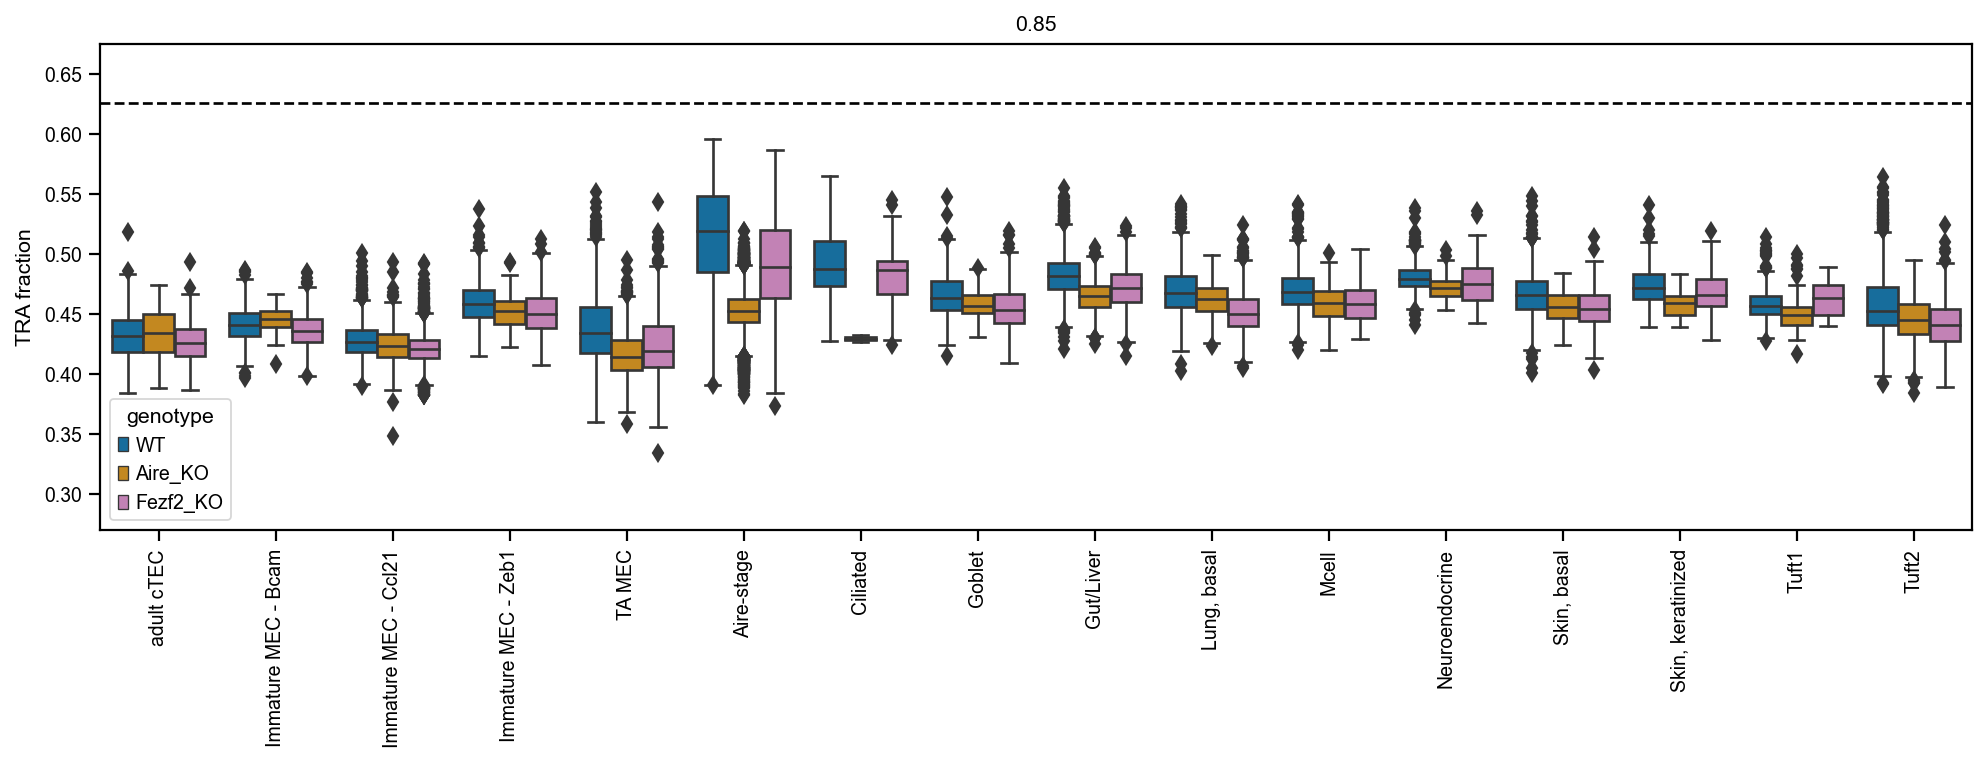

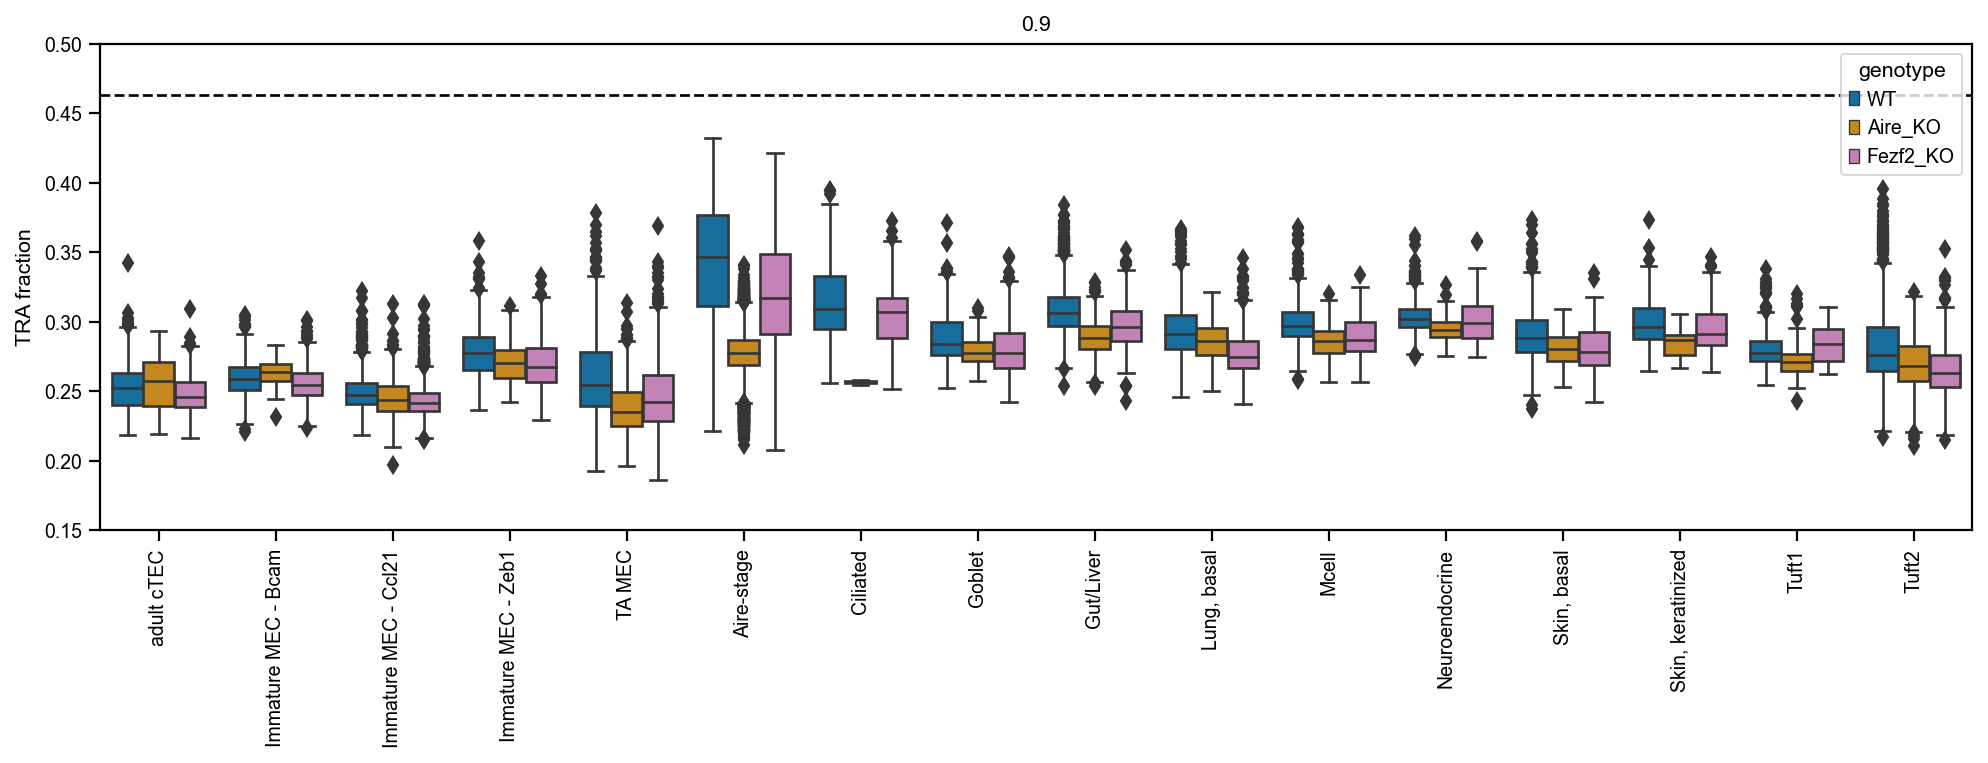

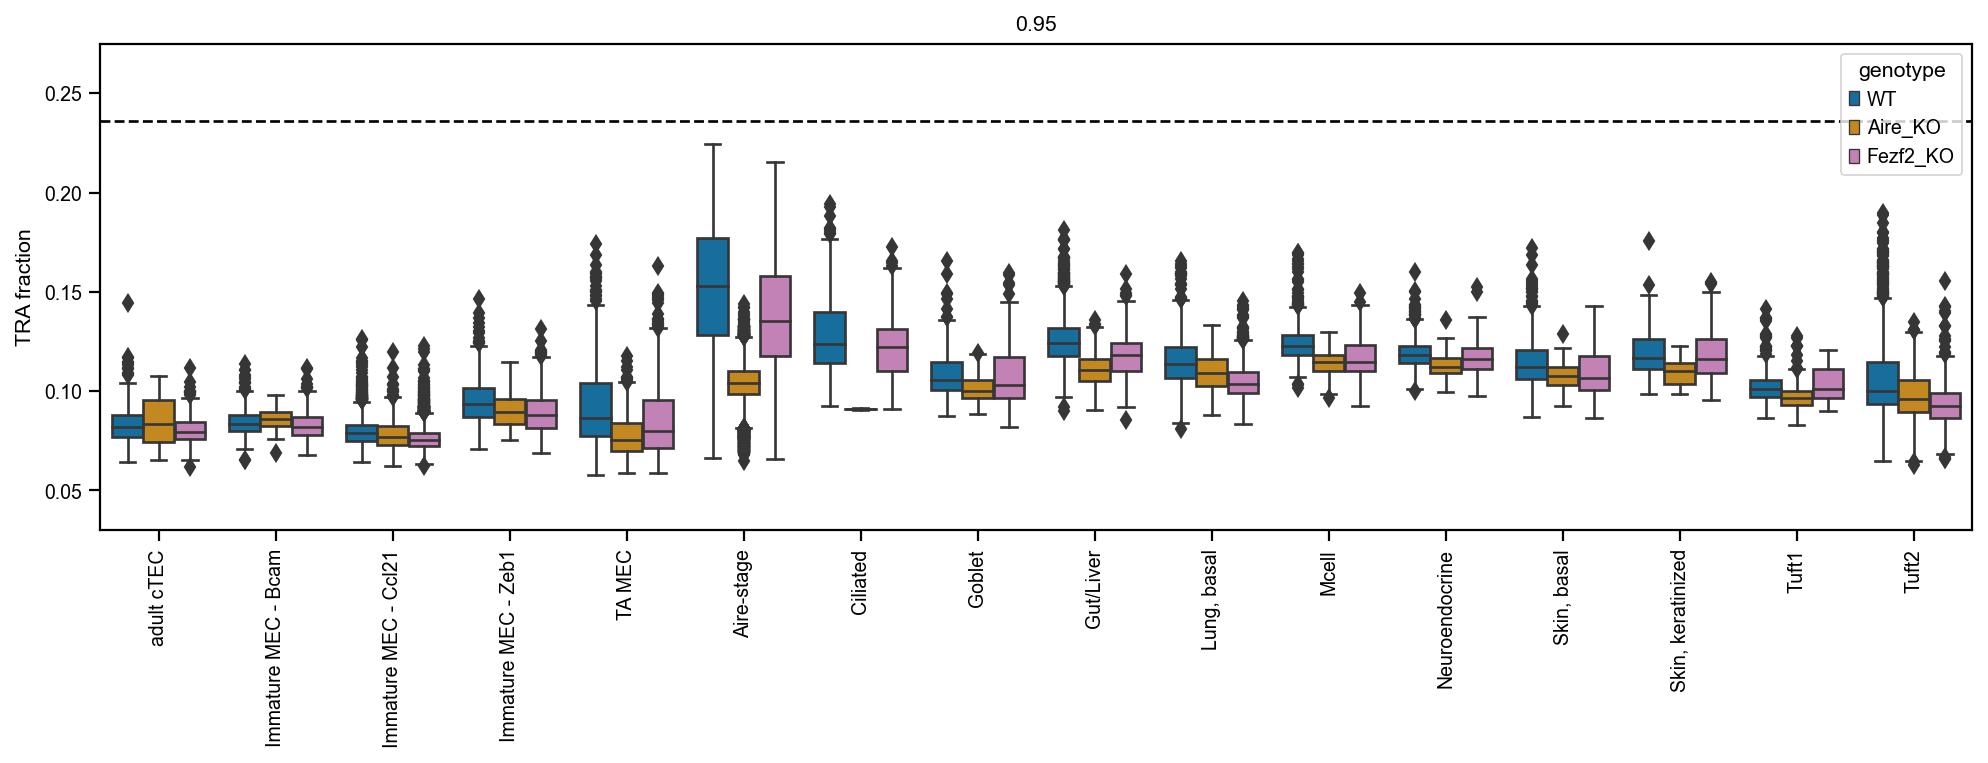

In [8]:
ylim = [(0.27, 0.675), (0.15, 0.5), (0.03, 0.275)]
for i,tau_threshold in enumerate([0.85, 0.9, 0.95]):
    TRAs = scores[scores[f"tau_TRA_{tau_threshold}"] | scores[f"entropy_TRA_{tau_threshold}"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    exprs = rna.tl.get_expression_matrix(adata, gene_data="scVI_normalized")
    exprs = exprs >= 0.1

    adata.obs[f"TRA_fraction_{tau_threshold}"] = exprs[TRAs].sum(axis=1)/exprs.sum(axis=1)
    adata.obs[f"TRA_number_{tau_threshold}"] = exprs[TRAs].sum(axis=1)

    plt.figure(figsize=(15,4))
    sns.boxplot(
        adata.obs,
        x="subclustered",
        y=f"TRA_fraction_{tau_threshold}",
        hue="genotype",
        hue_order=["WT", "Aire_KO", "Fezf2_KO"],
        palette=cmap[0:2] + [cmap[4]],
        order=["adult cTEC", "Immature MEC - Bcam", "Immature MEC - Ccl21",
               "Immature MEC - Zeb1", "TA MEC",  "Aire-stage", "Ciliated", "Goblet", 
               "Gut/Liver", "Lung, basal", "Mcell", "Neuroendocrine", "Skin, basal", 
               "Skin, keratinized", "Tuft1", "Tuft2"]
    )
    plt.axhline(y=len(TRAs)/adata.shape[1], color="black", linestyle="--")
    plt.xticks(rotation=90)
    plt.ylim(ylim[i][0], ylim[i][1])
    plt.xlabel("")
    plt.ylabel("TRA fraction")
    plt.title(tau_threshold)
    # plt.tight_layout()
    plt.savefig(f"../../analysis/paper_figures/S3/S3G_{tau_threshold}_TRA_fraction.pdf")
    plt.show()

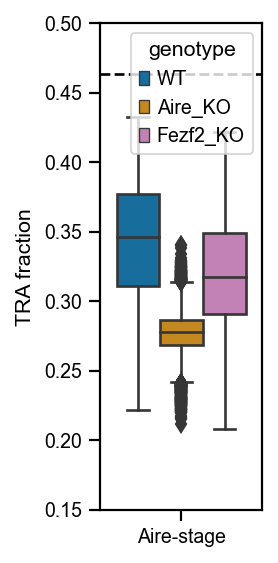

In [9]:
plt.figure(figsize=(1.3,4))
TRAs = scores[scores[f"tau_TRA_0.9"] | scores[f"entropy_TRA_0.9"]].index
sns.boxplot(
    adata[adata.obs.subclustered == "Aire-stage"].obs,
    x="subclustered",
    y=f"TRA_fraction_0.9",
    hue="genotype",
    hue_order=["WT", "Aire_KO", "Fezf2_KO"],
    palette=cmap[0:2] + [cmap[4]],
)
plt.axhline(y=len(TRAs)/adata.shape[1], color="black", linestyle="--")
plt.ylim(0.15, 0.5)
plt.xlabel("")
plt.ylabel("TRA fraction")
plt.savefig(f"../../analysis/paper_figures/2/2A_TRA_fraction.pdf")
plt.show()

In [10]:
obs_data = adata.obs
wt = obs_data[obs_data.genotype=="WT"]
fezf2 = obs_data[obs_data.genotype=="Fezf2_KO"]
aire = obs_data[obs_data.genotype=="Aire_KO"]

In [11]:
print("Tau 0.85")
print()
for cell_type in adata.obs.subclustered.unique():
    print(cell_type)
    print(tukey_hsd(
        wt[wt.subclustered == cell_type]["TRA_fraction_0.85"],
        aire[aire.subclustered == cell_type]["TRA_fraction_0.85"],
        fezf2[fezf2.subclustered == cell_type]["TRA_fraction_0.85"]
    ))
    print()

Tau 0.85

Gut/Liver
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.018     0.000     0.017     0.019
 (0 - 2)      0.010     0.000     0.008     0.012
 (1 - 0)     -0.018     0.000    -0.019    -0.017
 (1 - 2)     -0.008     0.000    -0.010    -0.006
 (2 - 0)     -0.010     0.000    -0.012    -0.008
 (2 - 1)      0.008     0.000     0.006     0.010


Tuft1
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.007     0.000     0.005     0.010
 (0 - 2)     -0.004     0.178    -0.010     0.001
 (1 - 0)     -0.007     0.000    -0.010    -0.005
 (1 - 2)     -0.012     0.000    -0.018    -0.006
 (2 - 0)      0.004     0.178    -0.001     0.010
 (2 - 1)      0.012     0.000     0.006     0.018


Aire-stage
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 -

In [12]:
print("Tau 0.9")
print()
for cell_type in adata.obs.subclustered.unique():
    print(cell_type)
    print(tukey_hsd(
        wt[wt.subclustered == cell_type]["TRA_fraction_0.9"],
        aire[aire.subclustered == cell_type]["TRA_fraction_0.9"],
        fezf2[fezf2.subclustered == cell_type]["TRA_fraction_0.9"]
    ))
    print()

Tau 0.9

Gut/Liver
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.019     0.000     0.018     0.021
 (0 - 2)      0.011     0.000     0.009     0.013
 (1 - 0)     -0.019     0.000    -0.021    -0.018
 (1 - 2)     -0.009     0.000    -0.011    -0.007
 (2 - 0)     -0.011     0.000    -0.013    -0.009
 (2 - 1)      0.009     0.000     0.007     0.011


Tuft1
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.007     0.000     0.005     0.010
 (0 - 2)     -0.004     0.154    -0.010     0.001
 (1 - 0)     -0.007     0.000    -0.010    -0.005
 (1 - 2)     -0.012     0.000    -0.018    -0.006
 (2 - 0)      0.004     0.154    -0.001     0.010
 (2 - 1)      0.012     0.000     0.006     0.018


Aire-stage
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 

In [13]:
print("Tau 0.95")
print()
for cell_type in adata.obs.subclustered.unique():
    print(cell_type)
    print(tukey_hsd(
        wt[wt.subclustered == cell_type]["TRA_fraction_0.95"],
        aire[aire.subclustered == cell_type]["TRA_fraction_0.95"],
        fezf2[fezf2.subclustered == cell_type]["TRA_fraction_0.95"]
    ))
    print()

Tau 0.95

Gut/Liver
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.014     0.000     0.014     0.015
 (0 - 2)      0.007     0.000     0.006     0.008
 (1 - 0)     -0.014     0.000    -0.015    -0.014
 (1 - 2)     -0.007     0.000    -0.009    -0.006
 (2 - 0)     -0.007     0.000    -0.008    -0.006
 (2 - 1)      0.007     0.000     0.006     0.009


Tuft1
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.004     0.000     0.003     0.006
 (0 - 2)     -0.002     0.409    -0.005     0.002
 (1 - 0)     -0.004     0.000    -0.006    -0.003
 (1 - 2)     -0.006     0.000    -0.010    -0.002
 (2 - 0)      0.002     0.409    -0.002     0.005
 (2 - 1)      0.006     0.000     0.002     0.010


Aire-stage
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 -

## cellxgene

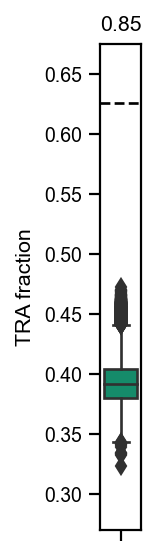

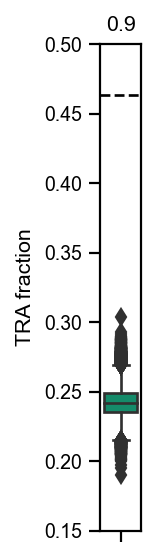

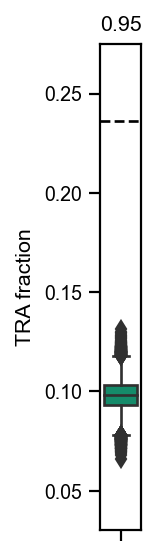

In [14]:
ylim = [(0.27, 0.675), (0.15, 0.5), (0.03, 0.275)]
cell_x_gene_TRA = cell_x_gene_exprs >= 0.1
for i,tau_threshold in enumerate([0.85, 0.9, 0.95]):
    TRAs = scores[scores[f"tau_TRA_{tau_threshold}"] | scores[f"entropy_TRA_{tau_threshold}"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    cell_x_gene_TRA[f"TRA_fraction_{tau_threshold}"] = cell_x_gene_TRA[TRAs].sum(axis=1)/cell_x_gene_TRA.sum(axis=1)

    plt.figure(figsize=(0.33,4))
    sns.boxplot(
        cell_x_gene_TRA,
        y=f"TRA_fraction_{tau_threshold}",
        palette=[cmap[2]],
    )
    plt.axhline(y=len(TRAs)/adata.shape[1], color="black", linestyle="--")
    plt.ylim(ylim[i][0], ylim[i][1])
    plt.xlabel("")
    plt.ylabel("TRA fraction")
    plt.xticks(rotation=90)
    plt.title(tau_threshold)
    plt.savefig(f"../../analysis/paper_figures/S3/S3G_{tau_threshold}_cellxgene_epithelium_TRA_fraction.pdf")
    plt.show()

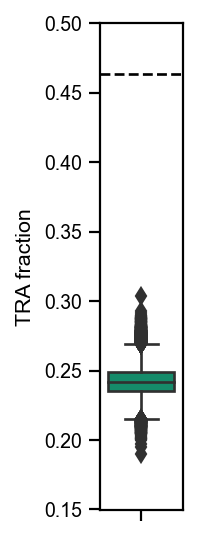

In [15]:
plt.figure(figsize=(0.66,4))
sns.boxplot(
    cell_x_gene_TRA,
    y=f"TRA_fraction_0.9",
    palette=[cmap[2]]
)
TRAs = scores[scores[f"tau_TRA_0.9"] | scores[f"entropy_TRA_0.9"]].index
plt.axhline(y=len(TRAs)/adata.shape[1], color="black", linestyle="--")
plt.ylim(0.15, 0.5)
plt.xlabel("")
plt.ylabel("TRA fraction")
plt.xticks(rotation=90)
plt.show()

# DE genes

In [16]:
with open('../../analysis/DE/filtered_genes.pkl', 'rb') as handle:
    filtered_genes = pickle.load(handle)

In [17]:
TRAs = scores[scores[f"tau_TRA_0.9"] | scores[f"entropy_TRA_0.9"]].index
filtered = filtered_genes[f"Fezf2_min_LFC"]
filtered["TRA"] = filtered.index.isin(TRAs)

In [18]:
filtered[(filtered.lfc_mean > 0) & (filtered.TRA) & (~filtered.index.isin(filtered_genes[f"Aire_min_LFC"].index))].shape

(170, 30)

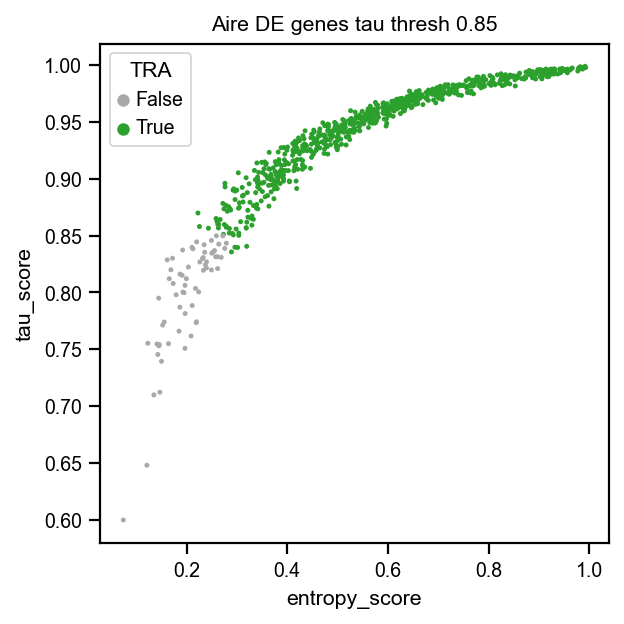

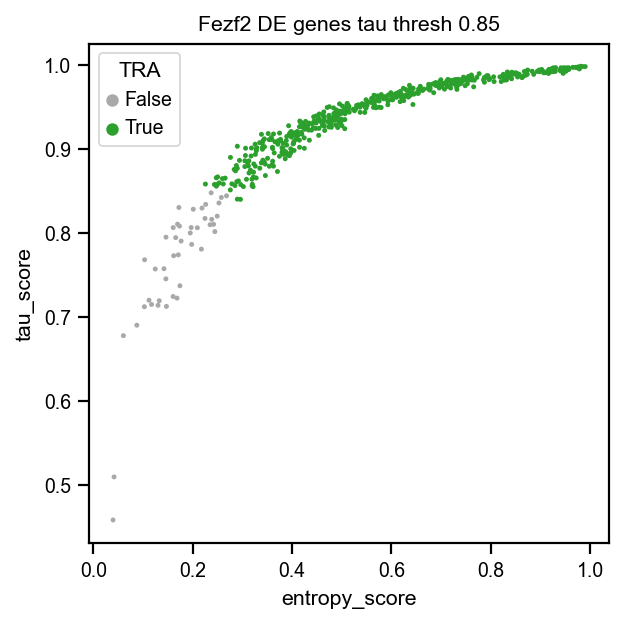

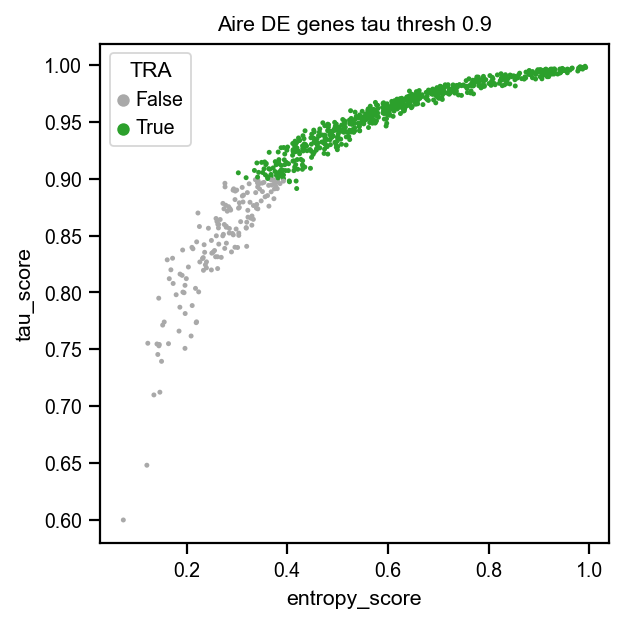

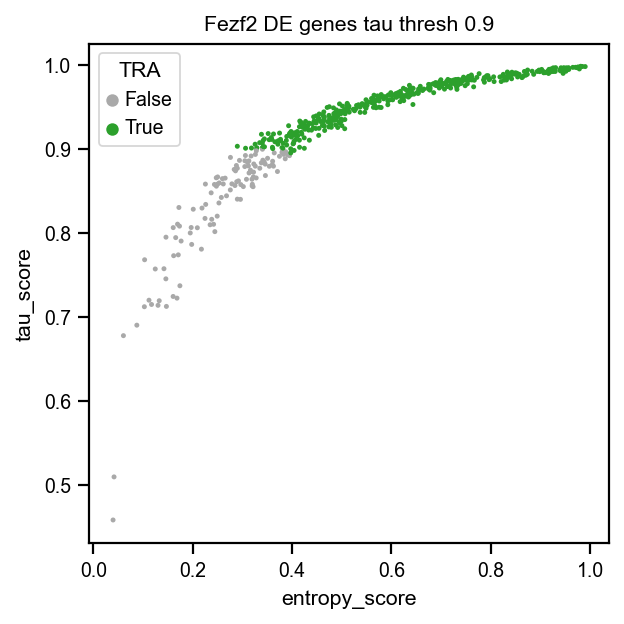

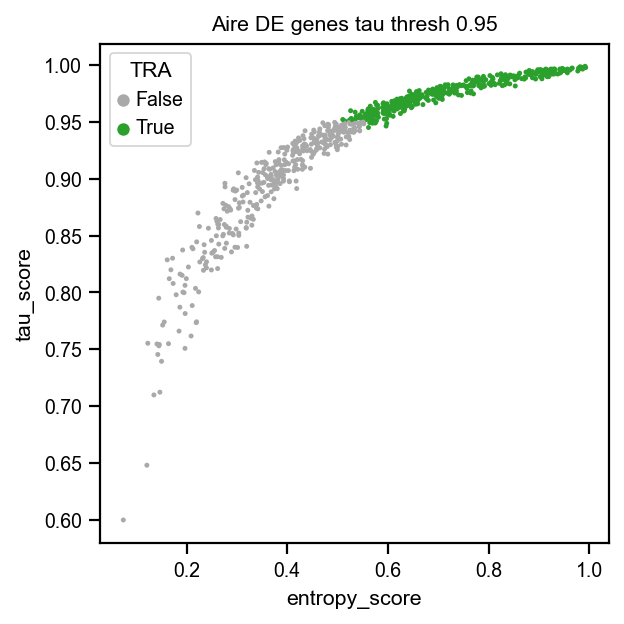

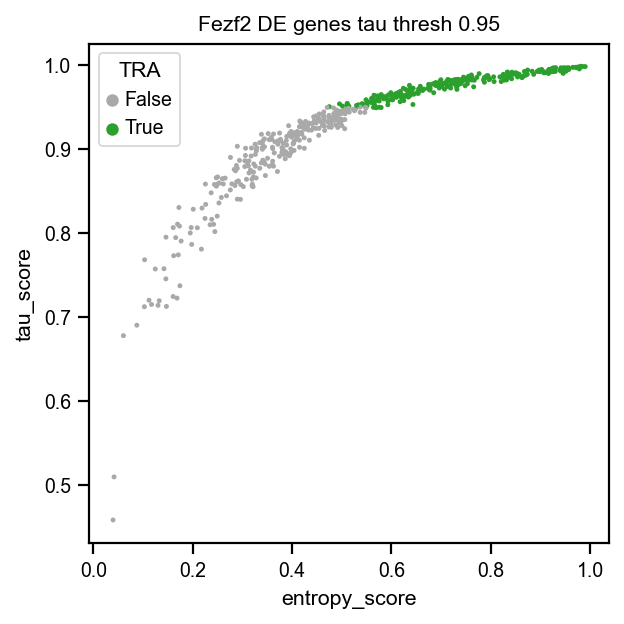

In [19]:
for i,tau_threshold in enumerate([0.85, 0.9, 0.95]):
    TRAs = scores[scores[f"tau_TRA_{tau_threshold}"] | scores[f"entropy_TRA_{tau_threshold}"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    for genotype in ["Aire", "Fezf2"]:
        filtered = filtered_genes[f"{genotype}_min_LFC"]
        filtered["tau_score"] = scores.tau_score
        filtered["entropy_score"] = scores.entropy_score
        filtered["TRA"] = filtered.index.isin(TRAs)
        

        fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(4,4))
        sns.scatterplot(
            filtered,
            x="entropy_score",
            y="tau_score",
            hue="TRA",
            palette=["darkgrey", "tab:green"],
            s=5,
            linewidth=0,
        )

        plt.title(f"{genotype} DE genes tau thresh {tau_threshold}")
        plt.tight_layout()
        if tau_threshold == 0.9:
            plt.savefig(f"../../analysis/paper_figures/2/2F_{genotype}_DE_genes_{tau_threshold}_TRAs.pdf")
        plt.show()
    

## Cellxgene expression of DE genes

In [20]:
cell_type_expression = np.load(f"{processedDataPath}/cell_x_gene_atlas/expression/cell_x_gene_atlas_cell_type_expression.npy")
index = pd.read_csv(f"{processedDataPath}/cell_x_gene_atlas/expression/cell_type_index.csv").cell_type
genes = pd.read_csv(f"{processedDataPath}/cell_x_gene_atlas/expression/keep_genes.csv").feature_name
cell_type_expression = pd.DataFrame(cell_type_expression, index=index, columns=genes)

Aire non-TRA


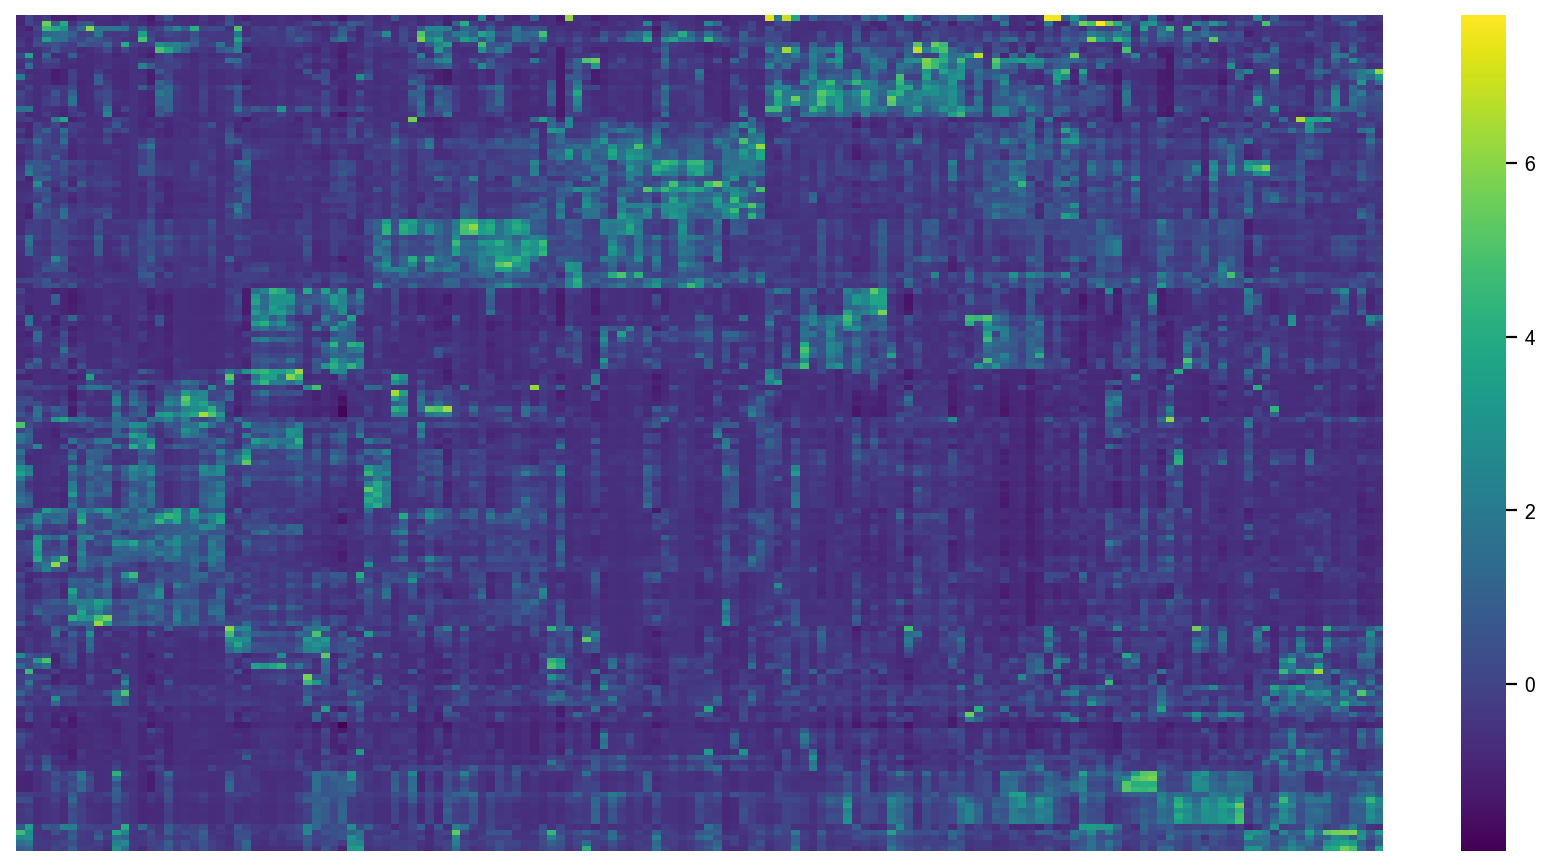

Aire TRA


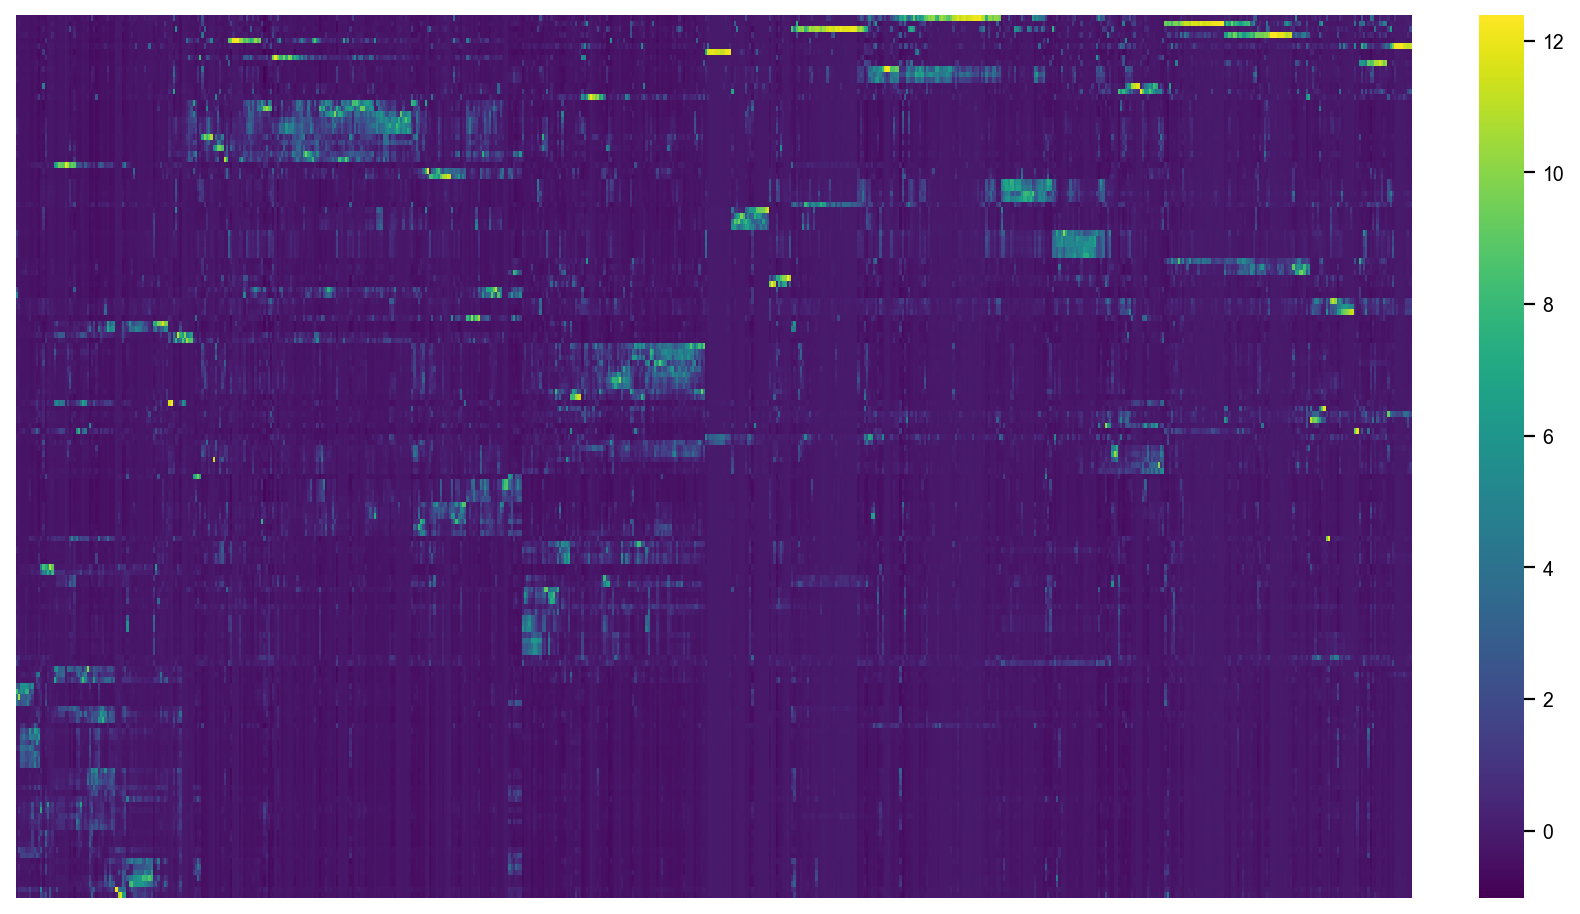

Fezf2 non-TRA


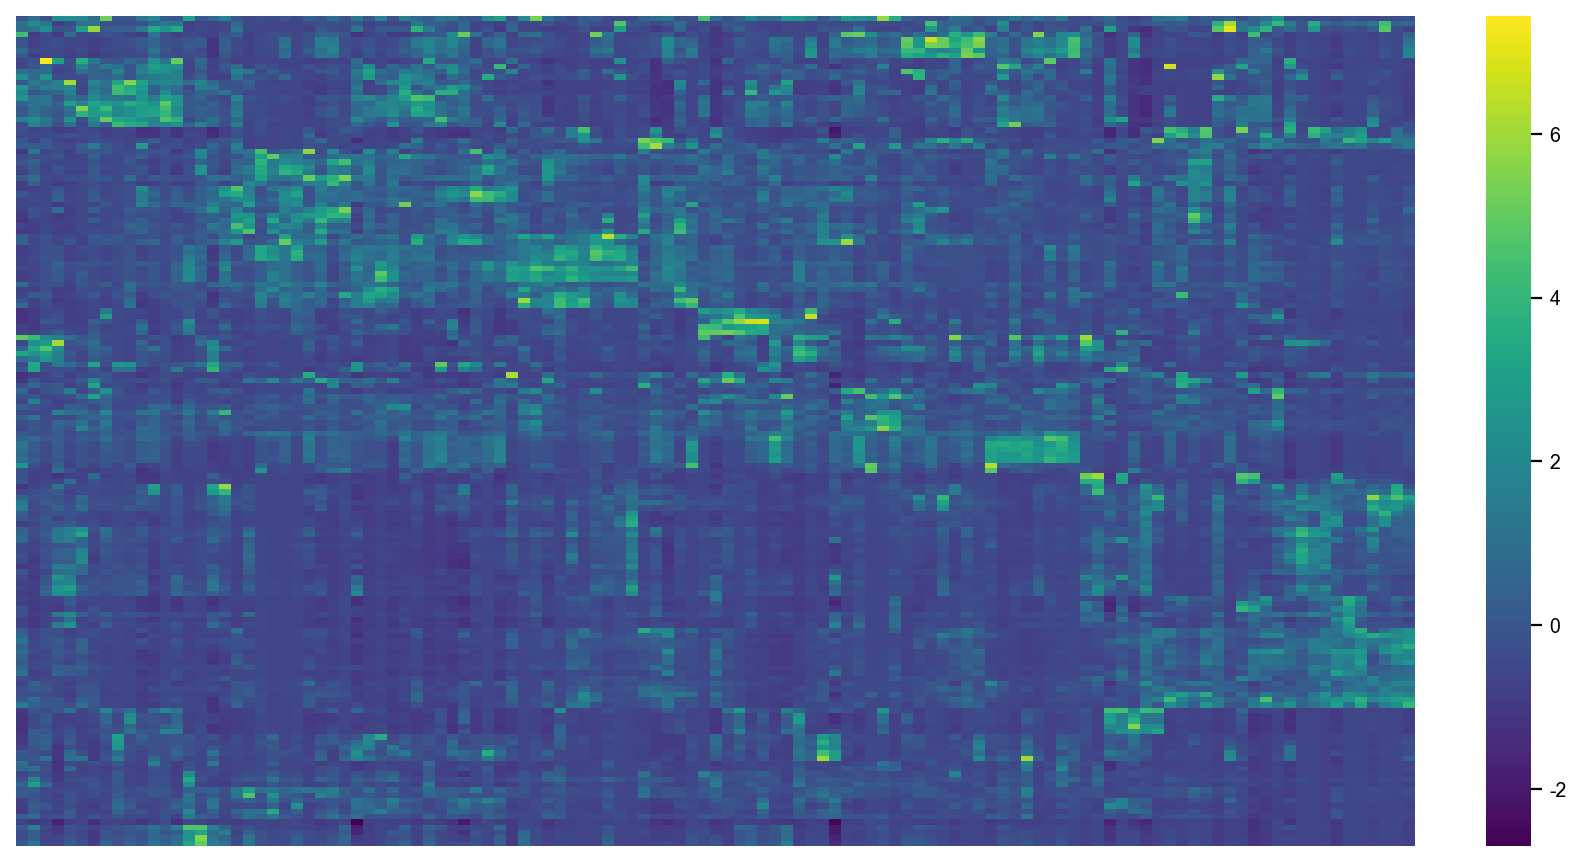

Fezf2 TRA


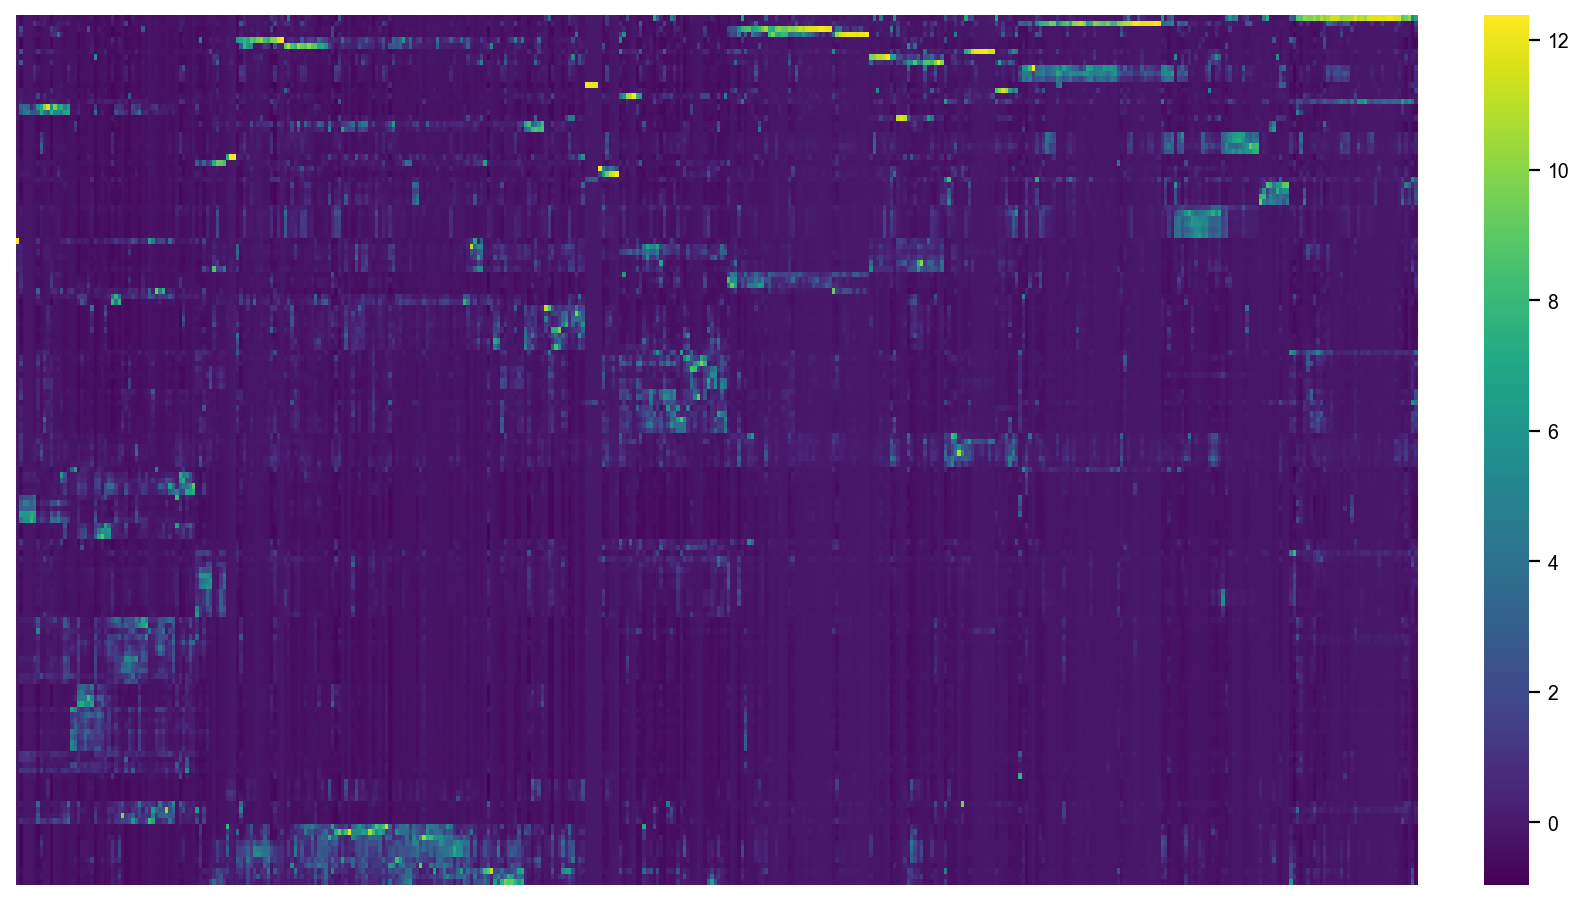

In [21]:
for genotype in ["Aire", "Fezf2"]:
    TRAs = scores[scores[f"tau_TRA_0.9"] | scores[f"entropy_TRA_0.9"]].index
    nonTRAs = scores[~scores.index.isin(TRAs)].index
    
    filtered = filtered_genes[f"{genotype}_min_LFC"]
    TRA = filtered[filtered.index.isin(TRAs)]
    nonTRA = filtered[filtered.index.isin(nonTRAs)]
    cg = sns.clustermap(
        cell_type_expression[nonTRA.index],
        z_score=1,
        figsize=(14,8),
        col_cluster=True,
        row_cluster=True,
        cmap="viridis",
    )
    cg.ax_cbar.set_position([cg.ax_heatmap.get_position().bounds[2]+0.2, cg.ax_heatmap.get_position().bounds[1], 0.02, cg.ax_heatmap.get_position().height])
    cg.ax_heatmap.set_xticks([])
    cg.ax_heatmap.set_yticks([])
    cg.ax_heatmap.set_xlabel("")
    cg.ax_heatmap.set_ylabel("")
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    print(f"{genotype} non-TRA")
    plt.show()
    
    cg = sns.clustermap(
        cell_type_expression[TRA.index],
        z_score=1,
        figsize=(14,8),
        col_cluster=True,
        row_cluster=True,
        cmap="viridis",
    )
    cg.ax_cbar.set_position([cg.ax_heatmap.get_position().bounds[2]+0.2, cg.ax_heatmap.get_position().bounds[1], 0.02, cg.ax_heatmap.get_position().height])
    cg.ax_heatmap.set_xticks([])
    cg.ax_heatmap.set_yticks([])
    cg.ax_heatmap.set_xlabel("")
    cg.ax_heatmap.set_ylabel("")
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    print(f"{genotype} TRA")
    plt.show()

# Save

In [22]:
with open('../../analysis/DE/filtered_genes.pkl', 'wb') as handle:
    pickle.dump(filtered_genes, handle)